# Mint

## Set up

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:

import os
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

import sys
# Add the workspace root to sys.path so 'scripts' can be imported
sys.path.append(str(Path.cwd().parents[2]))

from scripts.utils import tune_thresholds

In [3]:
PATH = Path.cwd().parents[2]
DATA_PATH = os.path.join(PATH, 'data/external/crpwarner/merged')

In [4]:
df = pd.read_csv(os.path.join(DATA_PATH, 'mint.csv')).set_index('address')
df.head()

,TP?
address,
0x93023F1D3525E273F291B6f76d2F5027A39BF302,1
0x2753dcE37A7eDB052a77832039bcc9aA49Ad8b25,0
0x94b7D24552933F50A5A5705C446528806dCeA381,0
0xE0b9d4146AaD6936cBfcBE4dAE47e34aAb96b093,0
0x10f6f2b97F3aB29583D9D38BaBF2994dF7220C21,1


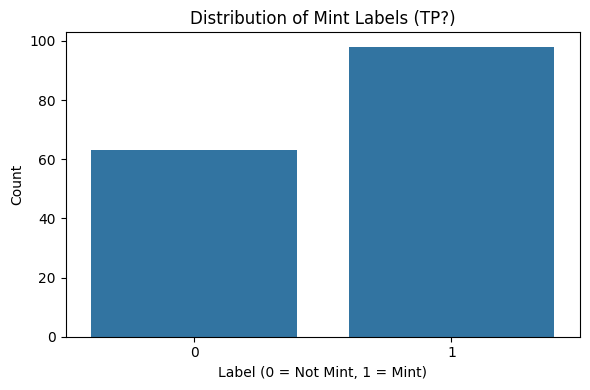

In [5]:
plt.figure(figsize=(6, 4))
sns.countplot(x="TP?", data=df)
plt.title("Distribution of Mint Labels (TP?)")
plt.xlabel("Label (0 = Not Mint, 1 = Mint)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


In [6]:
df["TP?"].value_counts()

TP?
1    98
0    63
Name: count, dtype: int64

In [7]:
y = np.array([df['TP?']]).T

In [8]:
def draw_confusion_matrix (model, y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    cm_display = ConfusionMatrixDisplay(cm)
    cm_display.plot(cmap=plt.cm.Blues,values_format='g')
    cm_display.ax_.set_title(model)
    plt.show()

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier

def get_report_all_ml(X_train, y_train, X_test, y_test):
    report_list = []

    models = {
        "LogisticRegression()": LogisticRegression(),
        "DecisionTreeClassifier()": DecisionTreeClassifier(),
        "RandomForestClassifier()": RandomForestClassifier(),
        "AdaBoostClassifier()": AdaBoostClassifier(),
        "ExtraTreesClassifier()": ExtraTreesClassifier(),
        "XGBClassifier()": XGBClassifier(),
        "LGBMClassifier()": LGBMClassifier(),
        "SVC()": SVC(),
        "GaussianNB()": GaussianNB(),
        "KNeighborsClassifier()": KNeighborsClassifier(),
        "SGDClassifier()": SGDClassifier(),
        "MLPClassifier()": MLPClassifier(),
    }

    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        # Generate classification report (as dict)
        report_dict = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
        draw_confusion_matrix (name, y_test, y_pred)
        # Average scores across all labels (macro average)
        avg_scores = report_dict["macro avg"]

        report_list.append({
            "Model": name,
            "Precision": avg_scores["precision"],
            "Recall": avg_scores["recall"],
            "F1-score": avg_scores["f1-score"]
        })

    df_report = pd.DataFrame(report_list)
    df_report = df_report.sort_values("F1-score", ascending=False).reset_index(drop=True)

    return df_report


In [10]:
sol_files = []

for file in list(Path(os.path.join(DATA_PATH, 'sol')).glob('*.sol')):
    if file.stem in df.index:
        sol_files.append(file)

hex_files = []

for file in list(Path(os.path.join(DATA_PATH, 'hex')).glob('*.hex')):
    if file.stem in df.index:
        hex_files.append(file)

### MPL

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

2025-07-18 19:14:04.059030: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [12]:
def Model(input_dim, output_dim):
    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(512, kernel_regularizer=regularizers.l1_l2(1e-6)),
        BatchNormalization(),
        LeakyReLU(0.01),
        Dropout(0.4),

        Dense(256, kernel_regularizer=regularizers.l1_l2(1e-6)),
        BatchNormalization(),
        LeakyReLU(0.01),
        Dropout(0.3),

        Dense(128, kernel_regularizer=regularizers.l1_l2(1e-6)),
        BatchNormalization(),
        LeakyReLU(0.01),
        Dropout(0.2),

        Dense(output_dim, activation='sigmoid')  # sigmoid for multi-label
    ])

    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(learning_rate=1e-6),
        metrics=['accuracy']
    )
    return model

## Byte Frequency

In [13]:
from scripts.feature_extractions.byte_freq import get_byte_freq_from_files

In [14]:
X  = get_byte_freq_from_files(hex_files)
X.head()

  0%|          | 0/161 [00:00<?, ?it/s]

100%|██████████| 161/161 [00:00<00:00, 393.09it/s]


,60,80,40,52,04,36,10,61,01,28,...,2a,78,c1,d9,1d,ba,ee,dc,be,27
address,,,,,,,,,,,,,,,,,,,,,
0x71a982a028c9d4b0566041a78df12b810462e155,417,251,58.0,108.0,52.0,17,22.0,157.0,215.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0x8275ebf521dc217aa79c88132017a5bcef001dd9,386,175,47.0,115.0,36.0,10,14.0,126.0,210.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0x292e89d5d5bdab3af2f5838c194c1983f0140b43,418,78,61.0,118.0,44.0,10,11.0,218.0,192.0,1.0,...,4.0,4.0,1.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0
0x2753dce37a7edb052a77832039bcc9aa49ad8b25,668,123,79.0,188.0,85.0,25,22.0,420.0,286.0,8.0,...,5.0,6.0,1.0,5.0,2.0,3.0,5.0,3.0,2.0,1.0
0xe1a0ce8b94c6a5e4791401086763d7bd0a6c18f5,270,92,45.0,82.0,28.0,8,14.0,136.0,158.0,4.0,...,0.0,2.0,0.0,2.0,2.0,0.0,0.0,2.0,0.0,1.0


In [15]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

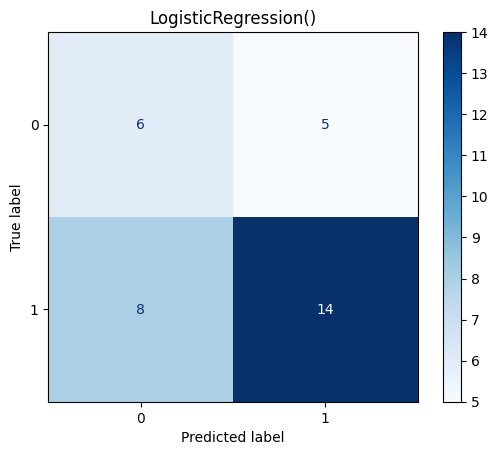

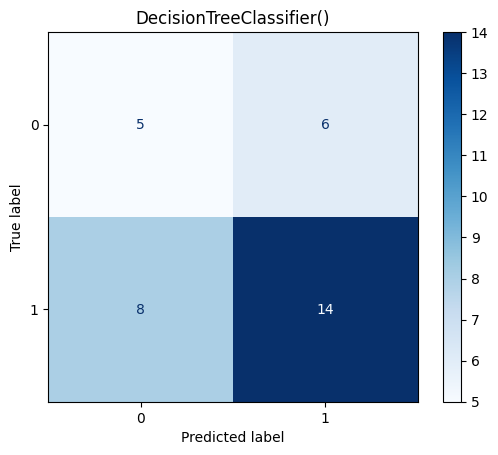

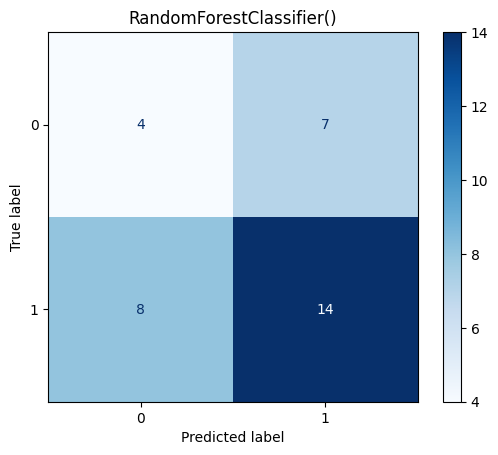

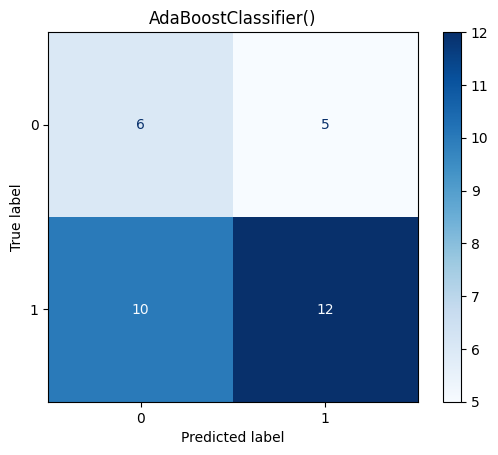

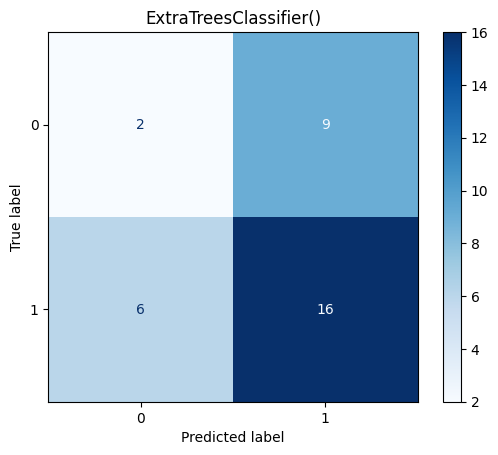

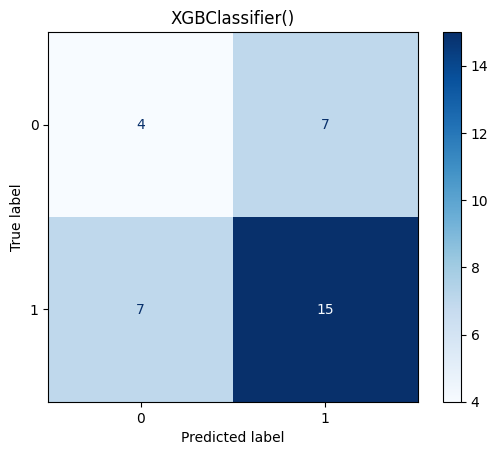

[LightGBM] [Info] Number of positive: 76, number of negative: 52
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000889 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4224
[LightGBM] [Info] Number of data points in the train set: 128, number of used features: 256
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.593750 -> initscore=0.379490
[LightGBM] [Info] Start training from score 0.379490
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

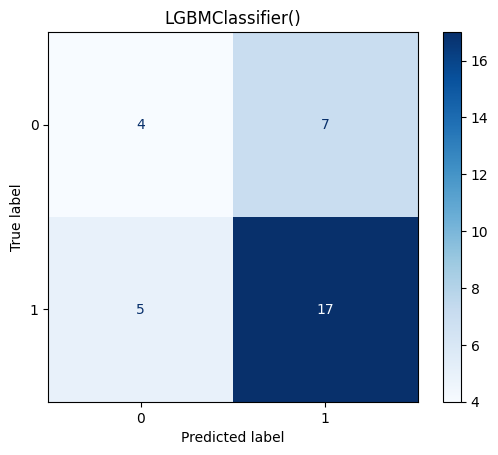

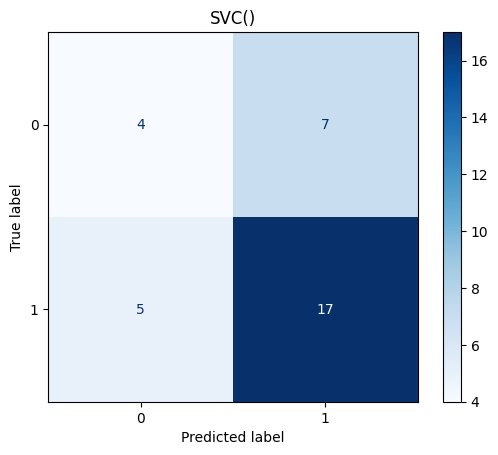

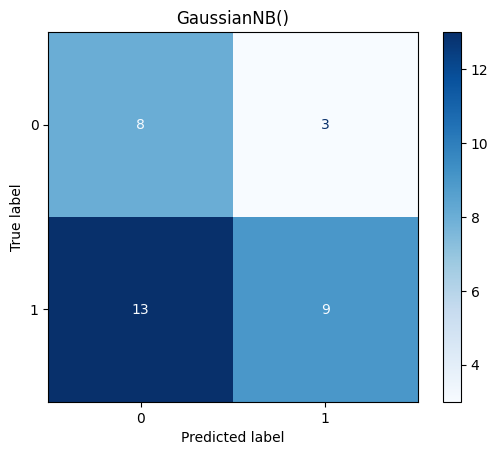

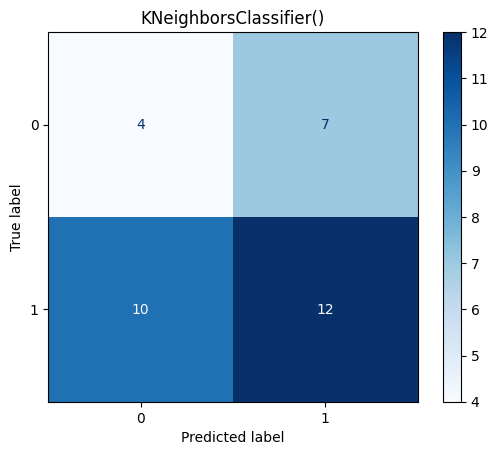

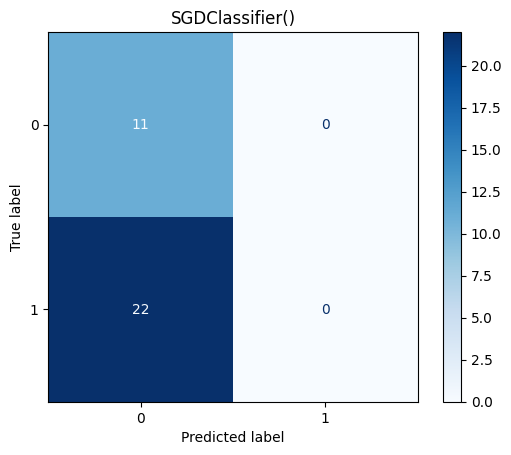

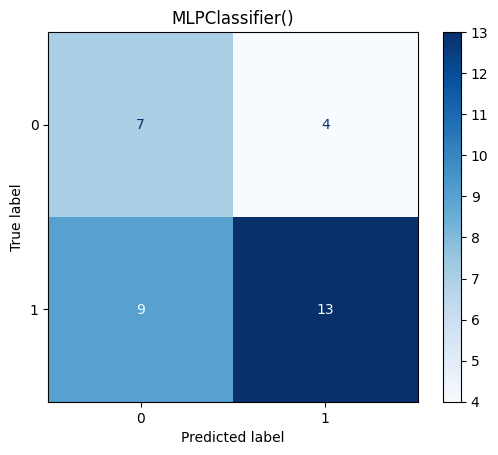

,Model,Precision,Recall,F1-score
0,MLPClassifier(),0.601103,0.613636,0.592593
1,LogisticRegression(),0.582707,0.590909,0.581463
2,SVC(),0.576389,0.568182,0.569565
3,LGBMClassifier(),0.576389,0.568182,0.569565
4,DecisionTreeClassifier(),0.542308,0.545455,0.541667
5,AdaBoostClassifier(),0.540441,0.545455,0.529915
6,XGBClassifier(),0.522727,0.522727,0.522727
7,GaussianNB(),0.565476,0.568182,0.514706
8,RandomForestClassifier(),0.500000,0.500000,0.499494
9,KNeighborsClassifier(),0.458647,0.454545,0.452683


In [16]:
df_report = get_report_all_ml(X_train, y_train, X_test, y_test)
df_report

### MPL Train & Evaluation

In [17]:
model = Model(input_dim=X.shape[1], output_dim=y.shape[1])
model.fit(X_train, y_train, validation_split=0.2, epochs=100, batch_size=32,
                    callbacks=[
                                EarlyStopping(monitor='val_loss',
                                             patience=5,
                                             restore_best_weights=True),
                                ReduceLROnPlateau(
                                  monitor='val_loss',
                                  factor=0.5,
                                  patience=5,
                                  verbose=1)
                               ]
                    )


Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - accuracy: 0.4697 - loss: 0.9048 - val_accuracy: 0.5385 - val_loss: 1.6388 - learning_rate: 1.0000e-06
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.4765 - loss: 0.9028 - val_accuracy: 0.5000 - val_loss: 1.2952 - learning_rate: 1.0000e-06
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.4423 - loss: 0.9490 - val_accuracy: 0.4615 - val_loss: 1.1470 - learning_rate: 1.0000e-06
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.3842 - loss: 0.9570 - val_accuracy: 0.4231 - val_loss: 1.0625 - learning_rate: 1.0000e-06
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.5357 - loss: 0.8486 - val_accuracy: 0.4615 - val_loss: 0.9846 - learning_rate: 1.0000e-06
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.4945 - loss: 0.8710 - val_accuracy: 0.4615 - val_loss: 0.9448 - learning_rate: 1.0000e-06
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.4538 - loss

In [18]:
y_prob = model.predict(X_test)
best_thresholds, _ = tune_thresholds(y_test, y_prob)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
Label 0: Best threshold = 0.00, Best f1 = 0.8000


In [19]:
y_pred = (y_prob >= best_thresholds).astype(int)

In [20]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.67      1.00      0.80        22

    accuracy                           0.67        33
   macro avg       0.33      0.50      0.40        33
weighted avg       0.44      0.67      0.53        33



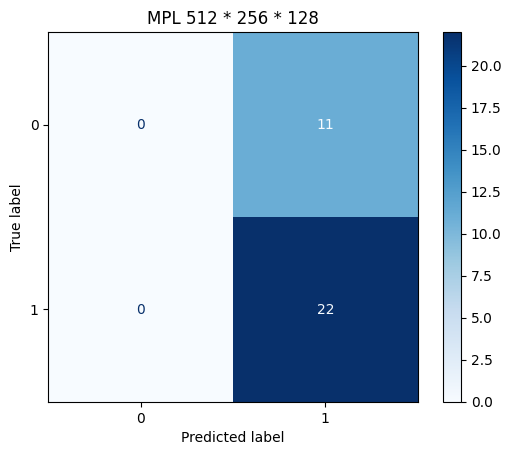

In [21]:
draw_confusion_matrix ('MPL 512 * 256 * 128', y_test, y_pred)

## Graph Statistic

In [22]:

from scripts.feature_extractions.graphs import get_graphs_stat_from_files

In [23]:
X  = get_graphs_stat_from_files(hex_files)
X.head()

100%|██████████| 161/161 [00:24<00:00,  6.59it/s]


,num_nodes,num_edges,avg_degree,density,connected_components,avg_clustering
address,,,,,,
0x71a982a028c9d4b0566041a78df12b810462e155,205,163,1.590244,0.003898,53,0.000000
0x8275ebf521dc217aa79c88132017a5bcef001dd9,155,118,1.522581,0.004943,44,0.000000
0x292e89d5d5bdab3af2f5838c194c1983f0140b43,194,96,0.989691,0.002564,112,0.012027
0x2753dce37a7edb052a77832039bcc9aa49ad8b25,339,178,1.050147,0.001553,192,0.003933
0xe1a0ce8b94c6a5e4791401086763d7bd0a6c18f5,113,78,1.380531,0.006163,46,0.000000


In [24]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

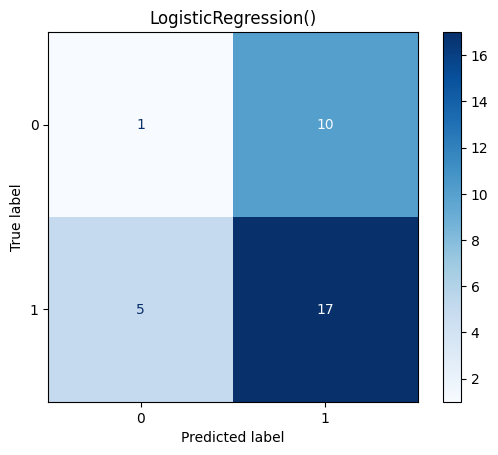

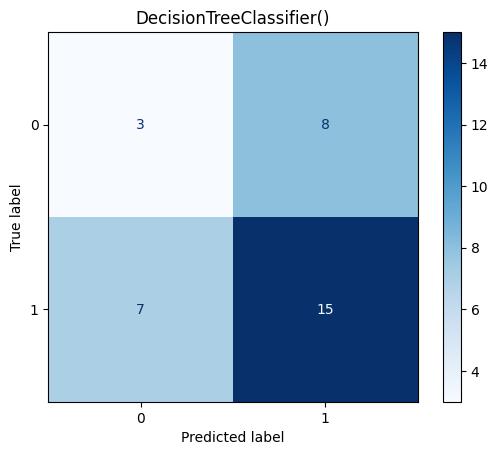

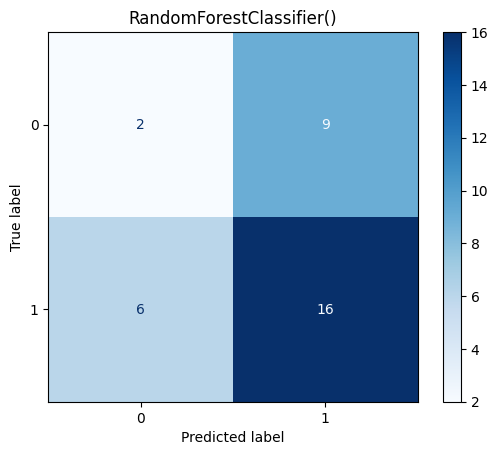

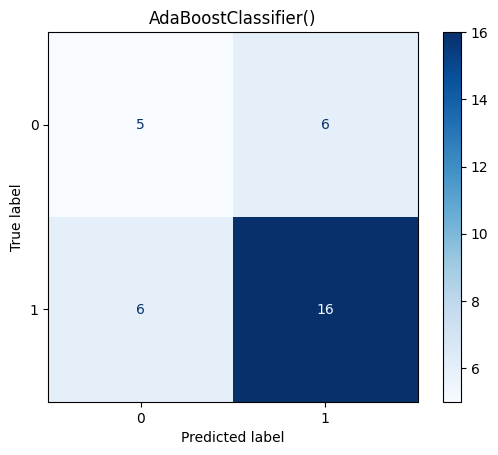

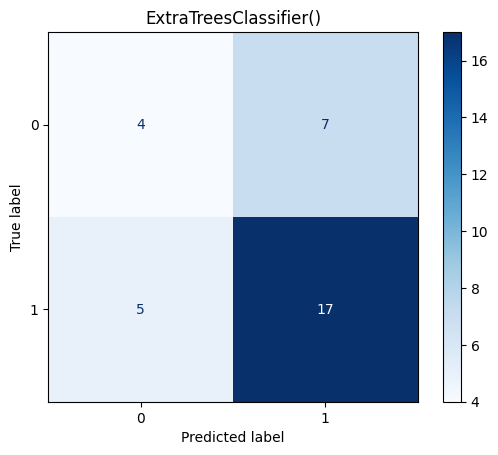

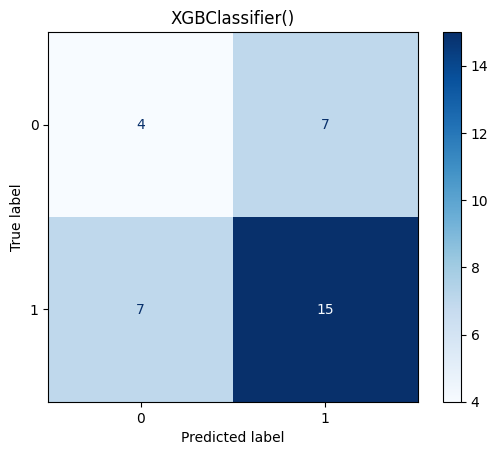

[LightGBM] [Info] Number of positive: 76, number of negative: 52
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000045 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 235
[LightGBM] [Info] Number of data points in the train set: 128, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.593750 -> initscore=0.379490
[LightGBM] [Info] Start training from score 0.379490
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

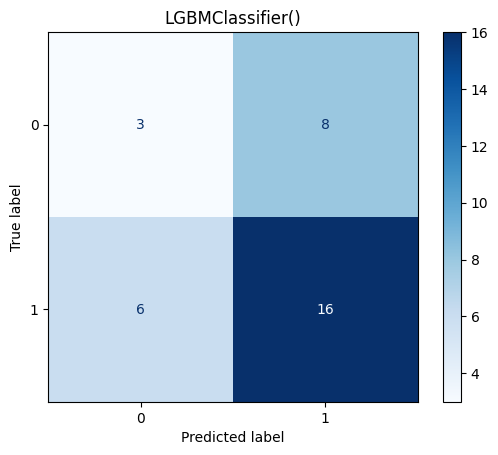

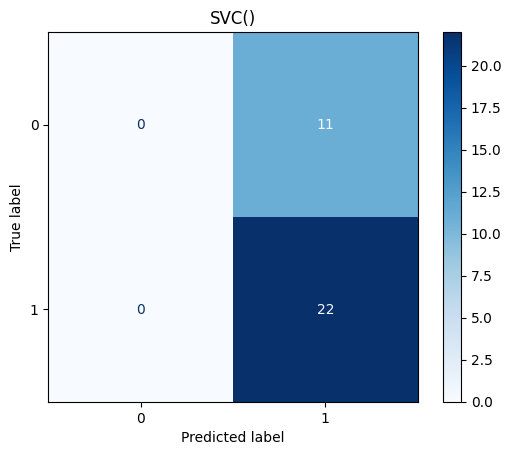

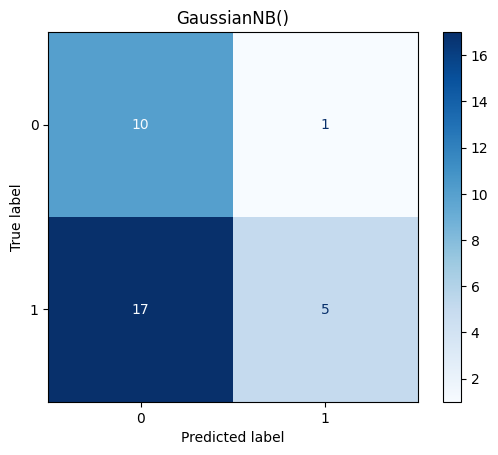

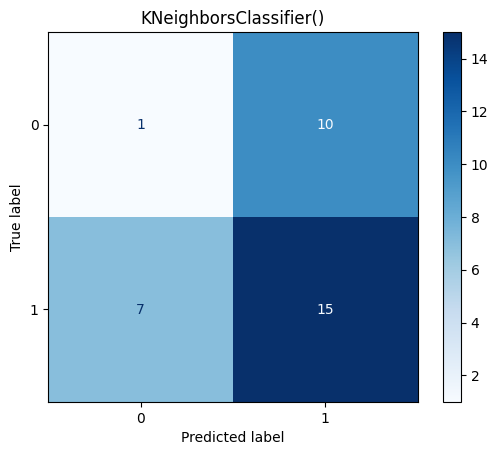

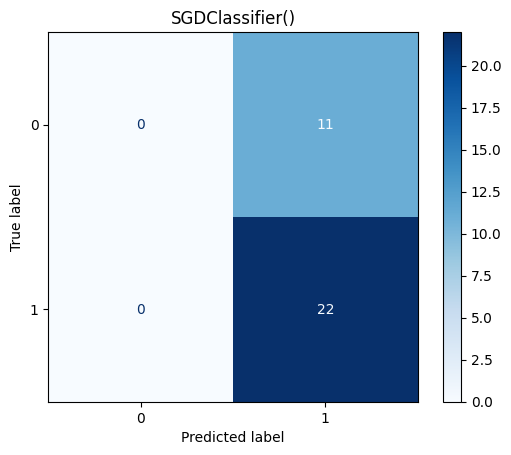

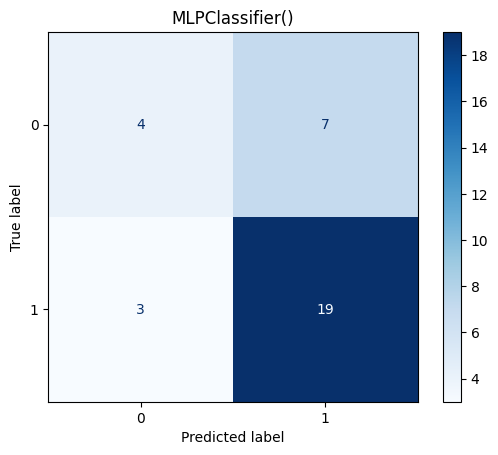

,Model,Precision,Recall,F1-score
0,MLPClassifier(),0.651099,0.613636,0.618056
1,AdaBoostClassifier(),0.590909,0.590909,0.590909
2,ExtraTreesClassifier(),0.576389,0.568182,0.569565
3,XGBClassifier(),0.522727,0.522727,0.522727
4,LGBMClassifier(),0.500000,0.500000,0.497826
5,DecisionTreeClassifier(),0.476087,0.477273,0.476190
6,RandomForestClassifier(),0.445000,0.454545,0.445689
7,GaussianNB(),0.601852,0.568182,0.441729
8,LogisticRegression(),0.398148,0.431818,0.405762
9,SVC(),0.333333,0.500000,0.400000


In [25]:
df_report = get_report_all_ml(X_train, y_train, X_test, y_test)
df_report

### MPL Train & Evaluation

In [26]:
model = Model(input_dim=X.shape[1], output_dim=y.shape[1])
model.fit(X_train, y_train, validation_split=0.2, epochs=100, batch_size=32,
                    callbacks=[
                                EarlyStopping(monitor='val_loss',
                                             patience=5,
                                             restore_best_weights=True),
                                ReduceLROnPlateau(
                                  monitor='val_loss',
                                  factor=0.5,
                                  patience=5,
                                  verbose=1)
                               ]
                    )


Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 263ms/step - accuracy: 0.4045 - loss: 1.0444 - val_accuracy: 0.4231 - val_loss: 3.6475 - learning_rate: 1.0000e-06
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.4968 - loss: 0.9493 - val_accuracy: 0.4231 - val_loss: 2.6651 - learning_rate: 1.0000e-06
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.4431 - loss: 0.9877 - val_accuracy: 0.4231 - val_loss: 2.2060 - learning_rate: 1.0000e-06
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.4752 - loss: 0.9852 - val_accuracy: 0.4231 - val_loss: 1.9246 - learning_rate: 1.0000e-06
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.4494 - loss: 1.0458 - val_accuracy: 0.4231 - val_loss: 1.7002 - learning_rate: 1.0000e-06
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.4810 - loss: 0.9686 - val_accuracy: 0.4231 - val_loss: 1.5578 - learning_rate: 1.0000e-06
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.4778 - loss

In [27]:
y_prob = model.predict(X_test)
best_thresholds, _ = tune_thresholds(y_test, y_prob)

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
Label 0: Best threshold = 0.00, Best f1 = 0.8000


In [28]:
y_pred = (y_prob >= best_thresholds).astype(int)

In [29]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.67      1.00      0.80        22

    accuracy                           0.67        33
   macro avg       0.33      0.50      0.40        33
weighted avg       0.44      0.67      0.53        33



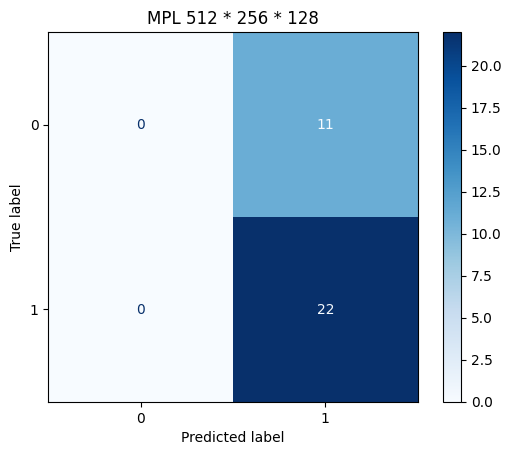

In [30]:
draw_confusion_matrix ('MPL 512 * 256 * 128', y_test, y_pred)

## N-Grams

In [31]:

from scripts.feature_extractions.n_grams import get_n_grams_from_files

In [32]:
X  = get_n_grams_from_files(hex_files)
X.head()

  1%|          | 1/161 [00:00<00:56,  2.83it/s]invalid instruction: PUSH30
invalid instruction: PUSH16
  4%|▎         | 6/161 [00:00<00:09, 15.75it/s]invalid instruction: PUSH18
invalid instruction: PUSH32
  6%|▌         | 10/161 [00:00<00:06, 21.95it/s]invalid instruction: PUSH31
invalid instruction: PUSH27
invalid instruction: PUSH27
 10%|▉         | 16/161 [00:00<00:04, 31.74it/s]invalid instruction: PUSH25
invalid instruction: PUSH32
invalid instruction: PUSH30
invalid instruction: PUSH32
 13%|█▎        | 21/161 [00:00<00:04, 30.53it/s]invalid instruction: PUSH15
invalid instruction: PUSH22
 16%|█▌        | 25/161 [00:01<00:06, 19.96it/s]invalid instruction: PUSH24
invalid instruction: PUSH30
invalid instruction: PUSH16
 18%|█▊        | 29/161 [00:01<00:05, 23.36it/s]invalid instruction: PUSH31
invalid instruction: PUSH31
 21%|██        | 34/161 [00:01<00:04, 27.36it/s]invalid instruction: PUSH15
invalid instruction: PUSH17
invalid instruction: PUSH28
invalid instruction: PUSH18
 2

,add add,add and,add and dup,add calldataload,add calldataload push,add calldataload swap,add dup,add dup add,add dup dup,add dup mstore,...,unknown jumpdest dup,unknown jumpdest push,unknown jumpdest swap,unknown log,unknown log push,unknown push,unknown swap,unknown swap dup,unknown unknown,unknown unknown unknown
address,,,,,,,,,,,,,,,,,,,,,
0x71a982a028c9d4b0566041a78df12b810462e155,0,0,0,0,0,0,14,0,10,0,...,0,0,0,0,0,1,0,0,3,2
0x8275ebf521dc217aa79c88132017a5bcef001dd9,0,0,0,0,0,0,6,0,6,0,...,2,0,0,0,0,0,0,0,3,0
0x292e89d5d5bdab3af2f5838c194c1983f0140b43,2,0,0,2,0,2,3,1,0,1,...,0,0,0,0,0,1,0,0,2,1
0x2753dce37a7edb052a77832039bcc9aa49ad8b25,3,0,0,2,0,2,9,1,3,1,...,0,0,0,1,1,0,0,0,6,4
0xe1a0ce8b94c6a5e4791401086763d7bd0a6c18f5,0,0,0,7,5,1,22,2,14,0,...,0,0,0,0,0,2,0,0,0,0


In [33]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

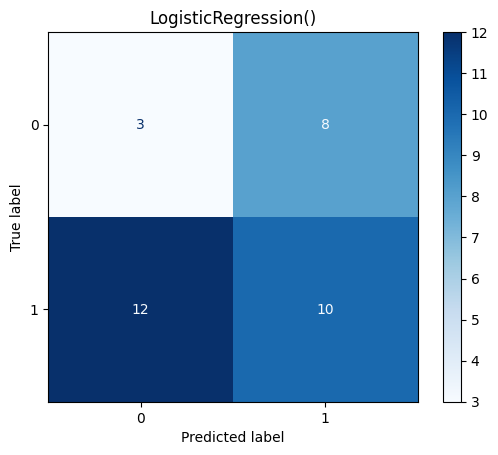

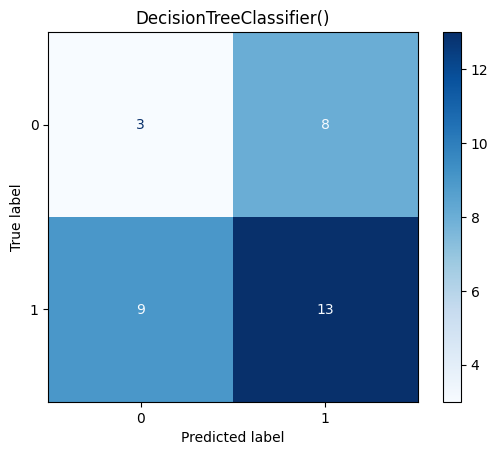

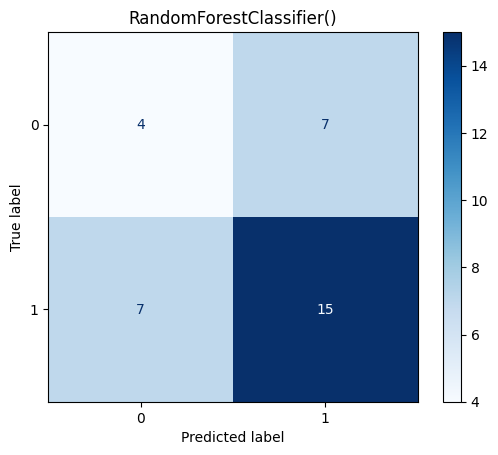

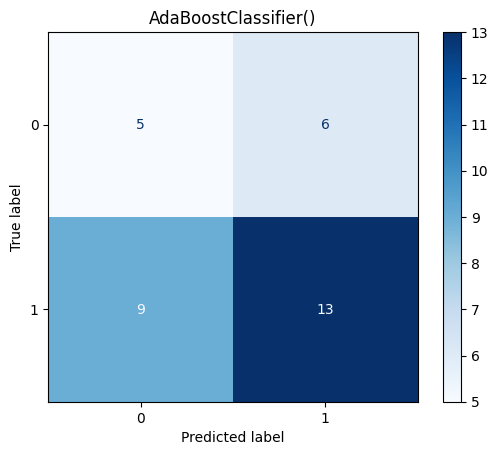

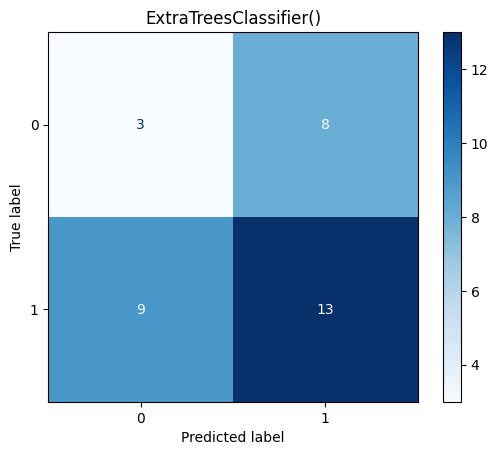

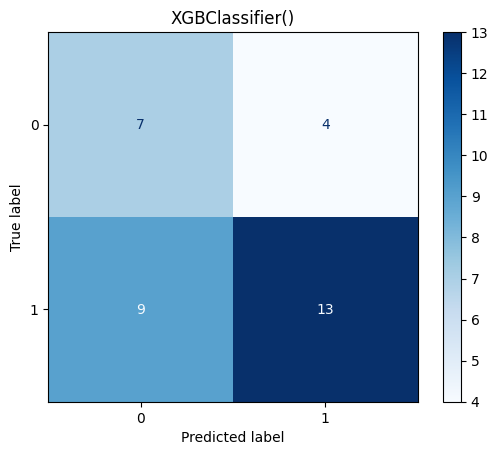

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 76, number of negative: 52
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003110 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11142
[LightGBM] [Info] Number of data points in the train set: 128, number of used features: 943
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.593750 -> initscore=0.379490
[LightGBM] [Info] Start training from score 0.379490
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

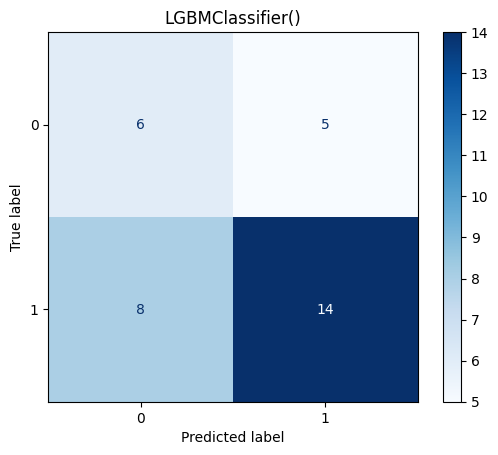

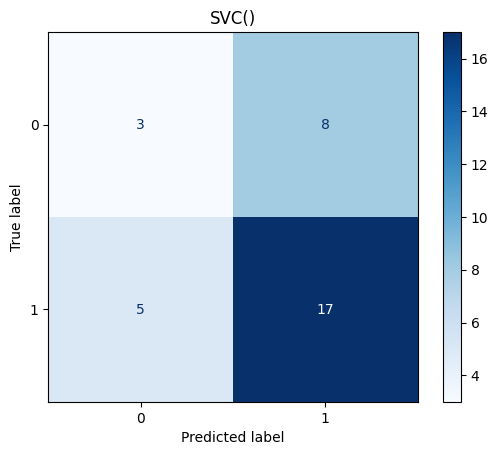

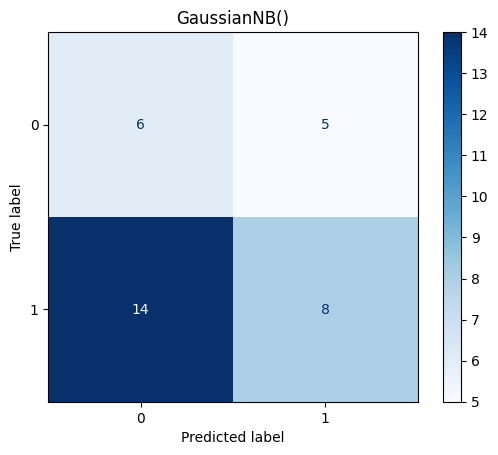

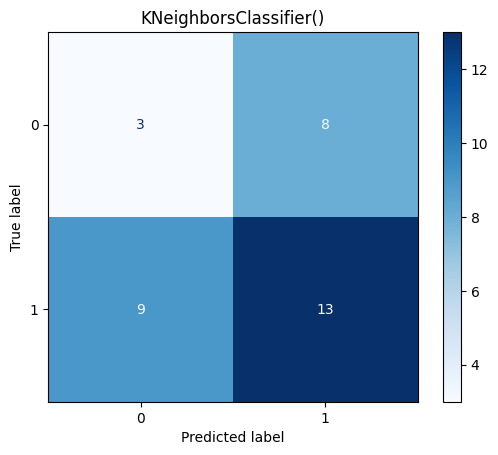

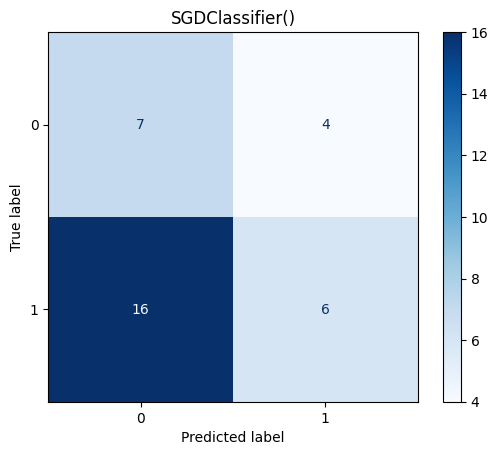

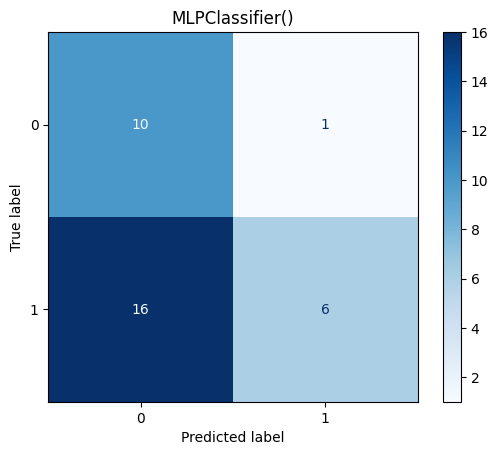

,Model,Precision,Recall,F1-score
0,XGBClassifier(),0.601103,0.613636,0.592593
1,LGBMClassifier(),0.582707,0.590909,0.581463
2,RandomForestClassifier(),0.522727,0.522727,0.522727
3,SVC(),0.527500,0.522727,0.519597
4,AdaBoostClassifier(),0.520677,0.522727,0.517073
5,MLPClassifier(),0.620879,0.590909,0.477167
6,ExtraTreesClassifier(),0.434524,0.431818,0.432760
7,DecisionTreeClassifier(),0.434524,0.431818,0.432760
8,KNeighborsClassifier(),0.434524,0.431818,0.432760
9,GaussianNB(),0.457692,0.454545,0.422120


In [34]:
df_report = get_report_all_ml(X_train, y_train, X_test, y_test)
df_report

### MPL Train & Evaluation

In [35]:
model = Model(input_dim=X.shape[1], output_dim=y.shape[1])
model.fit(X_train, y_train, validation_split=0.2, epochs=100, batch_size=32,
                    callbacks=[
                                EarlyStopping(monitor='val_loss',
                                             patience=5,
                                             restore_best_weights=True),
                                ReduceLROnPlateau(
                                  monitor='val_loss',
                                  factor=0.5,
                                  patience=5,
                                  verbose=1)
                               ]
                    )


Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 0.5790 - loss: 0.8169 - val_accuracy: 0.3846 - val_loss: 2.2454 - learning_rate: 1.0000e-06
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.4786 - loss: 0.8549 - val_accuracy: 0.3846 - val_loss: 1.7096 - learning_rate: 1.0000e-06
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5368 - loss: 0.8085 - val_accuracy: 0.4231 - val_loss: 1.4380 - learning_rate: 1.0000e-06
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5073 - loss: 0.9445 - val_accuracy: 0.4231 - val_loss: 1.2990 - learning_rate: 1.0000e-06
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5117 - loss: 0.7673 - val_accuracy: 0.4231 - val_loss: 1.1702 - learning_rate: 1.0000e-06
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.4825 - loss: 0.8500 - val_accuracy: 0.4231 - val_loss: 1.1047 - learning_rate: 1.0000e-06
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.3968 - loss

In [36]:
y_prob = model.predict(X_test)
best_thresholds, _ = tune_thresholds(y_test, y_prob)

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/stepWARNING:tensorflow:6 out of the last 6 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x13c08bec0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
Label 0: Best threshold = 0.13, Best f1 = 0.8148


In [37]:
y_pred = (y_prob >= best_thresholds).astype(int)

In [38]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.09      0.17        11
           1       0.69      1.00      0.81        22

    accuracy                           0.70        33
   macro avg       0.84      0.55      0.49        33
weighted avg       0.79      0.70      0.60        33



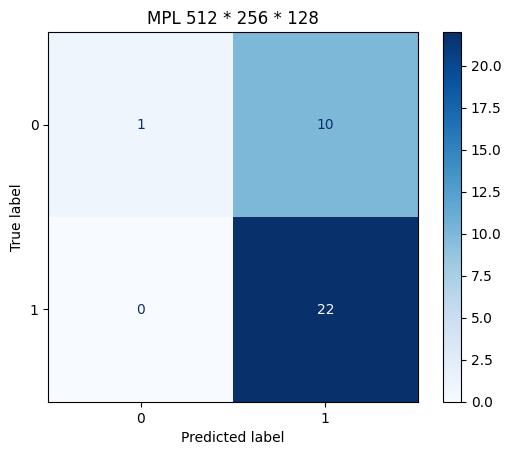

In [39]:
draw_confusion_matrix ('MPL 512 * 256 * 128', y_test, y_pred)

## Opcode Frequency

In [40]:
from scripts.feature_extractions.opcode_freq import get_opcodes_freq_from_files

In [41]:
X  = get_opcodes_freq_from_files(hex_files)
X.head()

  1%|          | 1/161 [00:00<00:18,  8.48it/s]invalid instruction: PUSH30
invalid instruction: PUSH16
  4%|▎         | 6/161 [00:00<00:06, 25.70it/s]invalid instruction: PUSH18
invalid instruction: PUSH32
  6%|▌         | 10/161 [00:00<00:05, 28.30it/s]invalid instruction: PUSH31
invalid instruction: PUSH27
invalid instruction: PUSH27
 10%|▉         | 16/161 [00:00<00:03, 37.21it/s]invalid instruction: PUSH25
invalid instruction: PUSH32
invalid instruction: PUSH30
 12%|█▏        | 20/161 [00:00<00:03, 35.53it/s]invalid instruction: PUSH32
invalid instruction: PUSH15
invalid instruction: PUSH22
 16%|█▌        | 25/161 [00:00<00:05, 23.46it/s]invalid instruction: PUSH24
invalid instruction: PUSH30
invalid instruction: PUSH16
invalid instruction: PUSH31
 19%|█▉        | 31/161 [00:01<00:04, 30.21it/s]invalid instruction: PUSH31
invalid instruction: PUSH15
 22%|██▏       | 36/161 [00:01<00:03, 33.98it/s]invalid instruction: PUSH17
invalid instruction: PUSH28
invalid instruction: PUSH18
in

,PUSH,MSTORE,CALLDATASIZE,LT,JUMPI,CALLDATALOAD,SWAP,DIV,AND,DUP,...,SIGNEXTEND,DELEGATECALL,SELFDESTRUCT,SGT,BASEFEE,EXTCODECOPY,MULMOD,XOR,DIFFICULTY,SDIV
address,,,,,,,,,,,,,,,,,,,,,
0x71a982a028c9d4b0566041a78df12b810462e155,701,103.0,15,10.0,75,27.0,372,20.0,118.0,565,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0x8275ebf521dc217aa79c88132017a5bcef001dd9,674,112.0,10,7.0,53,17.0,326,15.0,150.0,446,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0x292e89d5d5bdab3af2f5838c194c1983f0140b43,664,115.0,10,8.0,63,7.0,172,2.0,47.0,312,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0x2753dce37a7edb052a77832039bcc9aa49ad8b25,1155,179.0,23,13.0,101,7.0,264,4.0,76.0,517,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0xe1a0ce8b94c6a5e4791401086763d7bd0a6c18f5,419,78.0,8,13.0,36,15.0,200,6.0,40.0,302,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [42]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

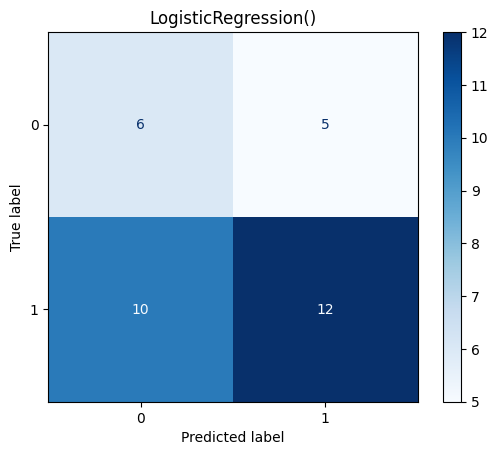

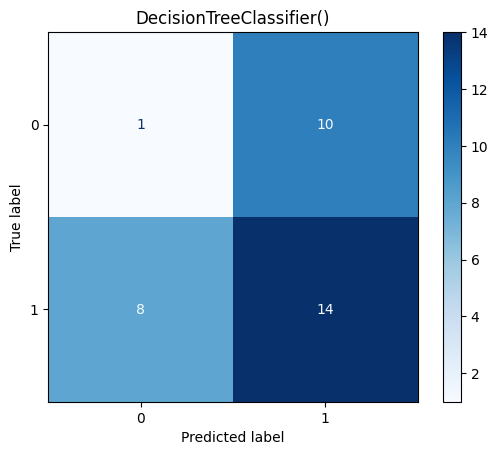

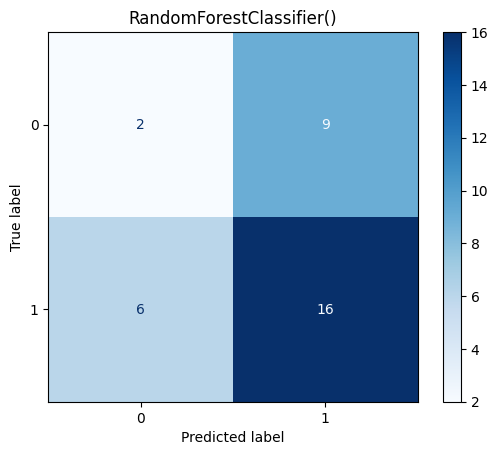

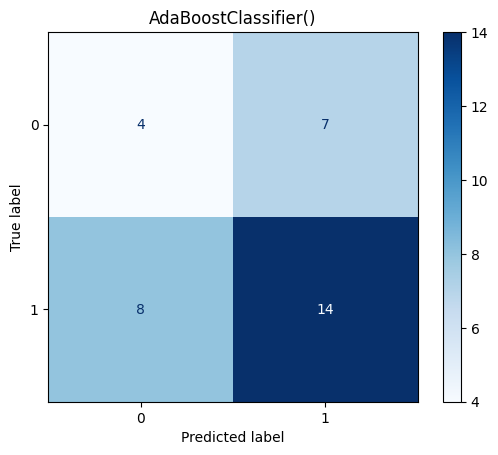

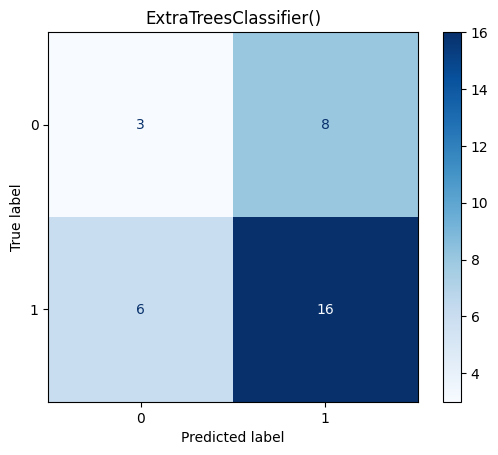

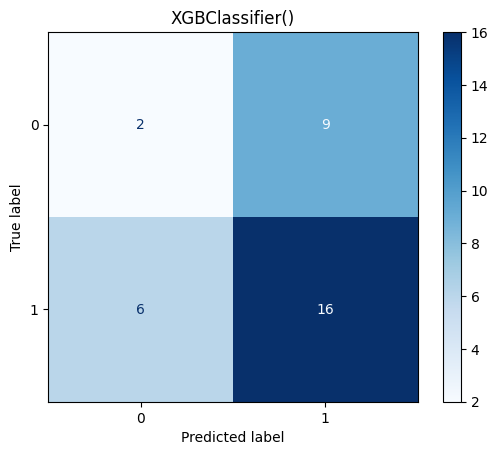

[LightGBM] [Info] Number of positive: 76, number of negative: 52
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000173 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1136
[LightGBM] [Info] Number of data points in the train set: 128, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.593750 -> initscore=0.379490
[LightGBM] [Info] Start training from score 0.379490
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

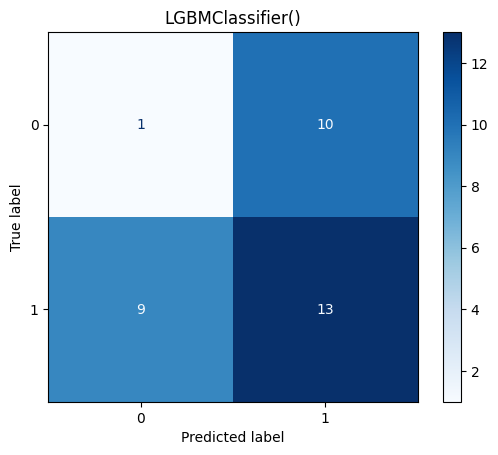

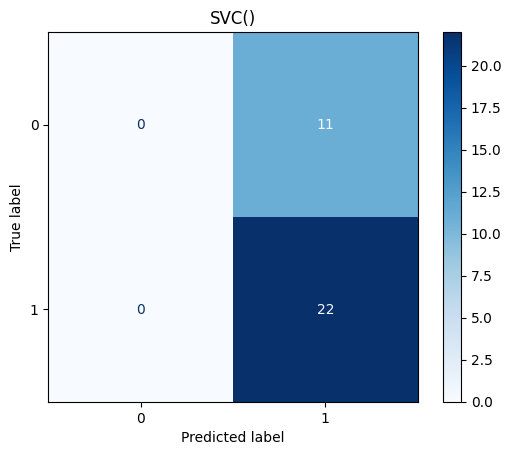

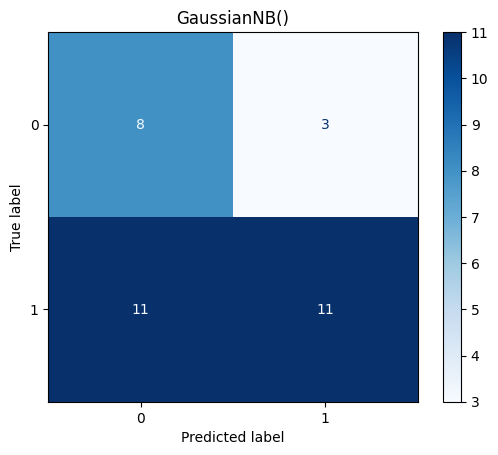

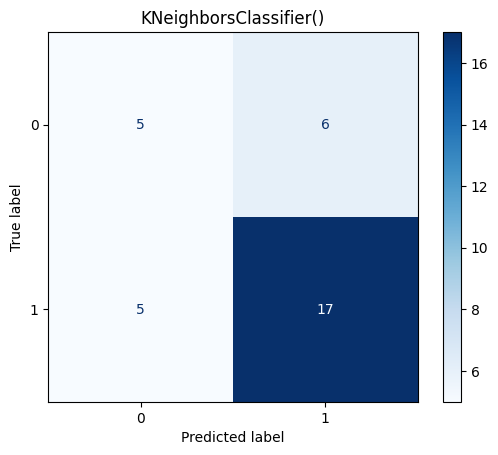

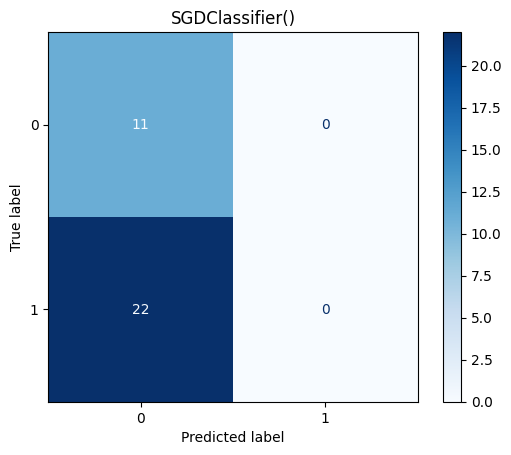

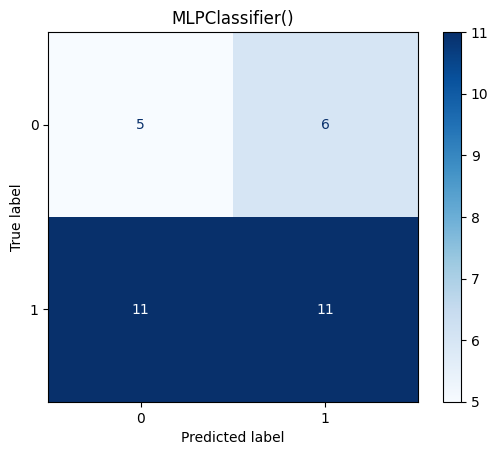

,Model,Precision,Recall,F1-score
0,KNeighborsClassifier(),0.619565,0.613636,0.615873
1,GaussianNB(),0.603383,0.613636,0.572222
2,LogisticRegression(),0.540441,0.545455,0.529915
3,AdaBoostClassifier(),0.500000,0.500000,0.499494
4,ExtraTreesClassifier(),0.500000,0.500000,0.497826
5,MLPClassifier(),0.479779,0.477273,0.467236
6,XGBClassifier(),0.445000,0.454545,0.445689
7,RandomForestClassifier(),0.445000,0.454545,0.445689
8,SVC(),0.333333,0.500000,0.400000
9,DecisionTreeClassifier(),0.347222,0.363636,0.354348


In [43]:
df_report = get_report_all_ml(X_train, y_train, X_test, y_test)
df_report

### MPL Train & Evaluation

In [44]:
model = Model(input_dim=X.shape[1], output_dim=y.shape[1])
model.fit(X_train, y_train, validation_split=0.2, epochs=100, batch_size=32,
                    callbacks=[
                                EarlyStopping(monitor='val_loss',
                                             patience=5,
                                             restore_best_weights=True),
                                ReduceLROnPlateau(
                                  monitor='val_loss',
                                  factor=0.5,
                                  patience=5,
                                  verbose=1)
                               ]
                    )


Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 207ms/step - accuracy: 0.5795 - loss: 0.7708 - val_accuracy: 0.5769 - val_loss: 2.1384 - learning_rate: 1.0000e-06
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.5778 - loss: 0.7759 - val_accuracy: 0.5769 - val_loss: 1.2367 - learning_rate: 1.0000e-06
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.6213 - loss: 0.7446 - val_accuracy: 0.5769 - val_loss: 0.9526 - learning_rate: 1.0000e-06
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.5772 - loss: 0.7615 - val_accuracy: 0.5769 - val_loss: 0.8701 - learning_rate: 1.0000e-06
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5574 - loss: 0.8306 - val_accuracy: 0.5769 - val_loss: 0.7539 - learning_rate: 1.0000e-06
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.6859 - loss: 0.6385 - val_accuracy: 0.5769 - val_loss: 0.7149 - learning_rate: 1.0000e-06
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5277 - loss

In [45]:
y_prob = model.predict(X_test)
best_thresholds, _ = tune_thresholds(y_test, y_prob)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step
Label 0: Best threshold = 0.48, Best f1 = 0.8077


In [46]:
y_pred = (y_prob >= best_thresholds).astype(int)

In [47]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.67      0.18      0.29        11
           1       0.70      0.95      0.81        22

    accuracy                           0.70        33
   macro avg       0.68      0.57      0.55        33
weighted avg       0.69      0.70      0.63        33



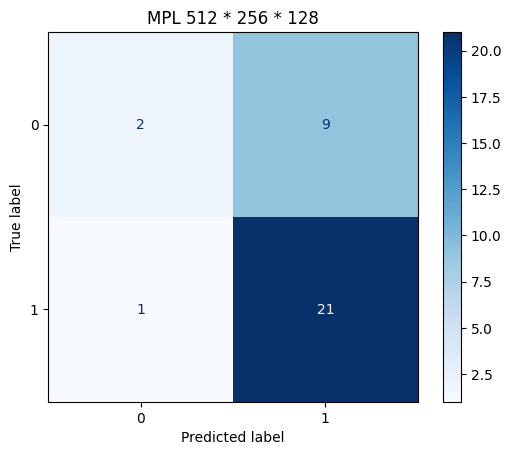

In [48]:
draw_confusion_matrix ('MPL 512 * 256 * 128', y_test, y_pred)

## TF-IDF

### Hex

In [49]:
from scripts.feature_extractions.tf_idf import get_tf_idf_vector

In [50]:
X, _  = get_tf_idf_vector(hex_files)
X

100%|██████████| 161/161 [00:00<00:00, 8844.80it/s]


<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 161 stored elements and shape (161, 161)>

In [51]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

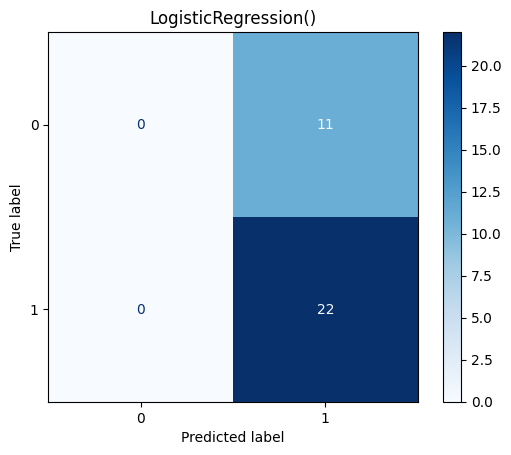

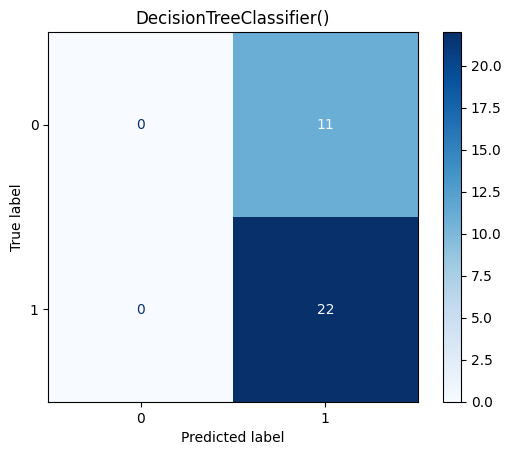

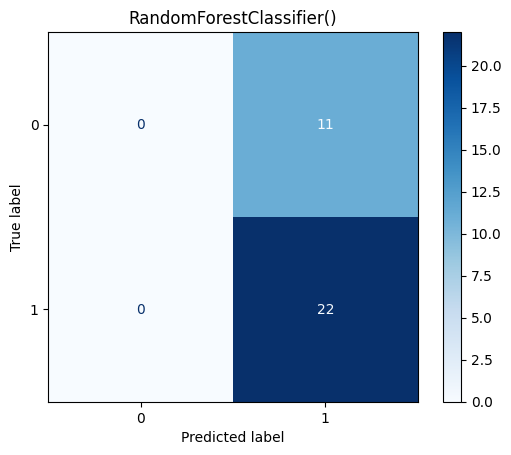

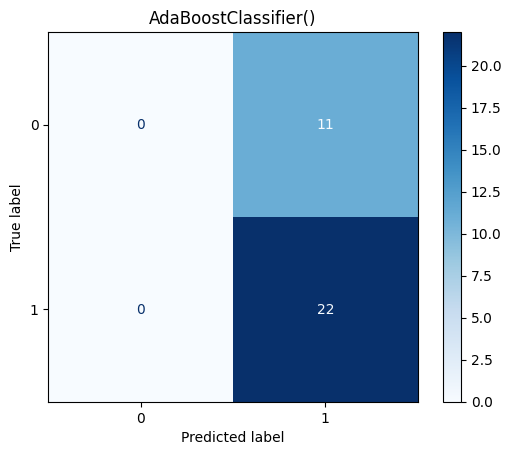

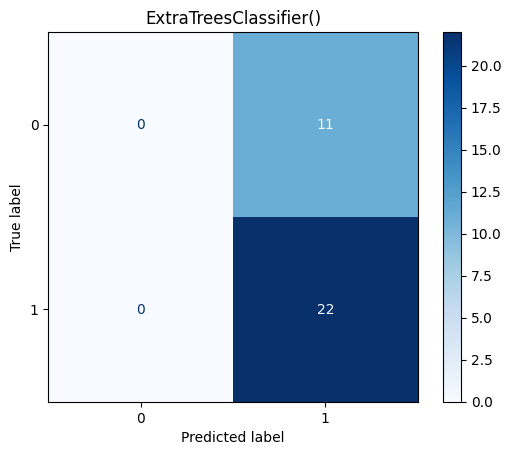

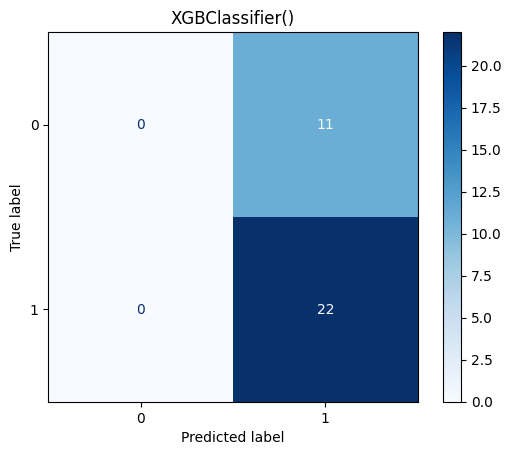

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 76, number of negative: 52
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 128, number of used features: 0
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.593750 -> initscore=0.379490
[LightGBM] [Info] Start training from score 0.379490
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because th

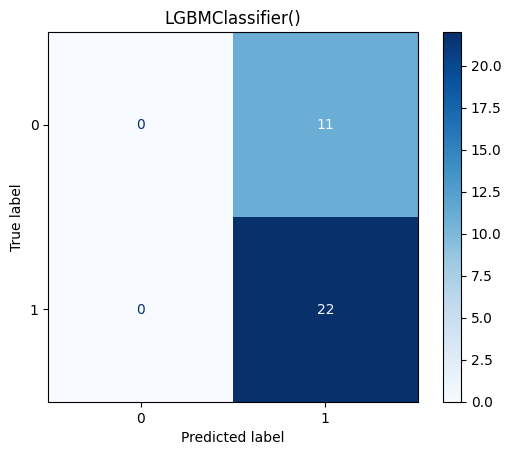

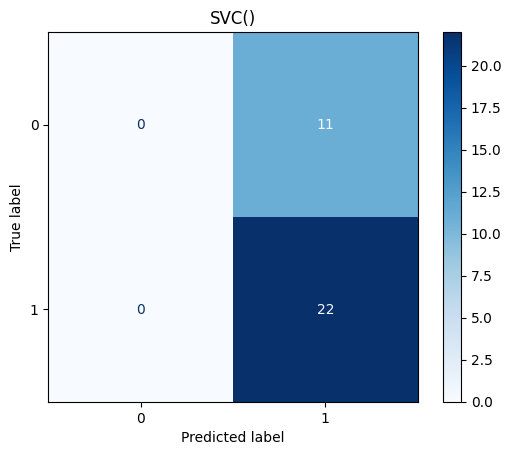

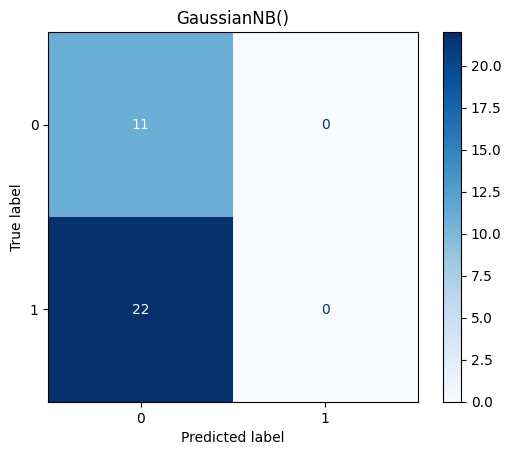

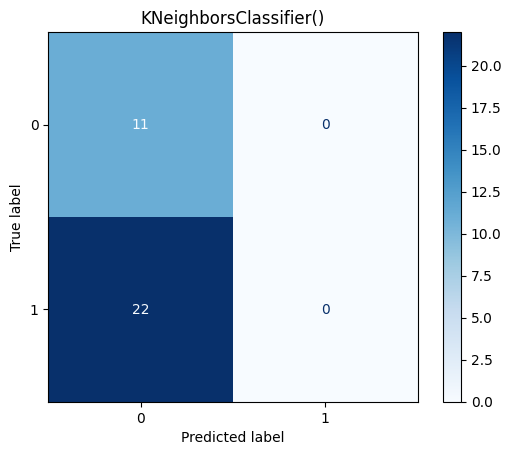

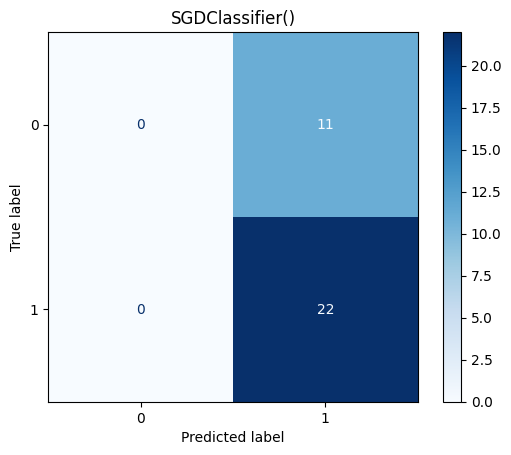

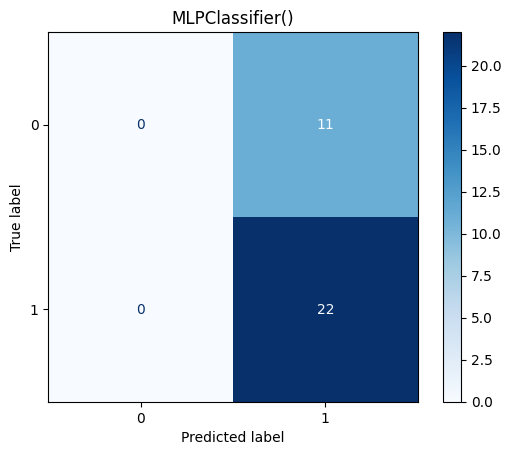

,Model,Precision,Recall,F1-score
0,LogisticRegression(),0.333333,0.5,0.40
1,DecisionTreeClassifier(),0.333333,0.5,0.40
2,RandomForestClassifier(),0.333333,0.5,0.40
3,AdaBoostClassifier(),0.333333,0.5,0.40
4,ExtraTreesClassifier(),0.333333,0.5,0.40
5,XGBClassifier(),0.333333,0.5,0.40
6,LGBMClassifier(),0.333333,0.5,0.40
7,SVC(),0.333333,0.5,0.40
8,MLPClassifier(),0.333333,0.5,0.40
9,SGDClassifier(),0.333333,0.5,0.40


In [52]:
df_report = get_report_all_ml(X_train.toarray(), y_train, X_test.toarray(), y_test)
df_report

#### MPL Train & Evaluation

In [53]:
model = Model(input_dim=X.shape[1], output_dim=y.shape[1])
model.fit(X_train, y_train, validation_split=0.2, epochs=100, batch_size=32,
                    callbacks=[
                                EarlyStopping(monitor='val_loss',
                                             patience=5,
                                             restore_best_weights=True),
                                ReduceLROnPlateau(
                                  monitor='val_loss',
                                  factor=0.5,
                                  patience=5,
                                  verbose=1)
                               ]
                    )


Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 152ms/step - accuracy: 0.4985 - loss: 0.8316 - val_accuracy: 0.5000 - val_loss: 0.7059 - learning_rate: 1.0000e-06
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.5160 - loss: 0.7569 - val_accuracy: 0.4231 - val_loss: 0.7091 - learning_rate: 1.0000e-06
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.5060 - loss: 0.8177 - val_accuracy: 0.4615 - val_loss: 0.7110 - learning_rate: 1.0000e-06
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.5306 - loss: 0.8181 - val_accuracy: 0.4615 - val_loss: 0.7116 - learning_rate: 1.0000e-06
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.4304 - loss: 0.9299 - val_accuracy: 0.4231 - val_loss: 0.7116 - learning_rate: 1.0000e-06
Epoch 6/100
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.7500 - loss: 0.7325
Epoch 6: ReduceLROnPlateau reducing learning rate to 4.999999987376214e-07.
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.6744 - loss: 0.74

In [54]:
y_prob = model.predict(X_test)
best_thresholds, _ = tune_thresholds(y_test, y_prob)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
Label 0: Best threshold = 0.00, Best f1 = 0.8000


In [55]:
y_pred = (y_prob >= best_thresholds).astype(int)

In [56]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.67      1.00      0.80        22

    accuracy                           0.67        33
   macro avg       0.33      0.50      0.40        33
weighted avg       0.44      0.67      0.53        33



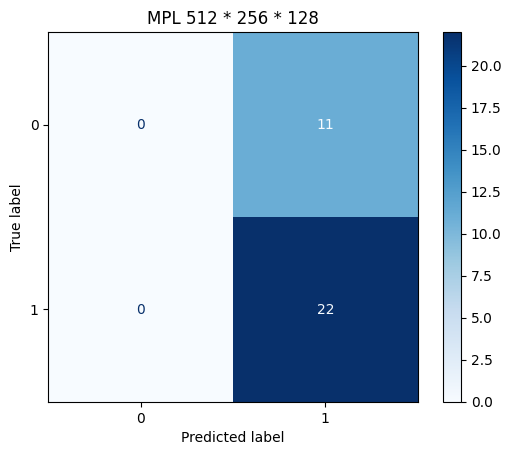

In [57]:
draw_confusion_matrix ('MPL 512 * 256 * 128', y_test, y_pred)

### Sol

In [58]:
X, _  = get_tf_idf_vector(sol_files)
X

100%|██████████| 161/161 [00:00<00:00, 1720.11it/s]


<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 56379 stored elements and shape (161, 8221)>

In [59]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

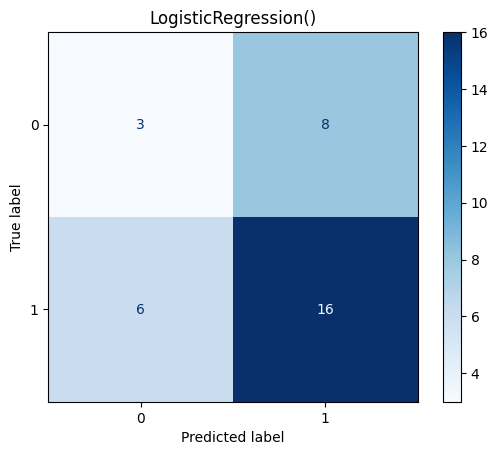

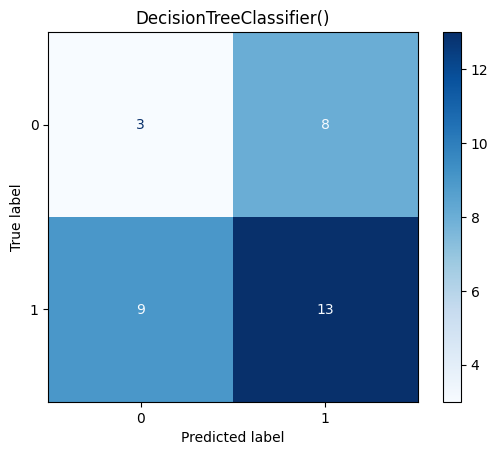

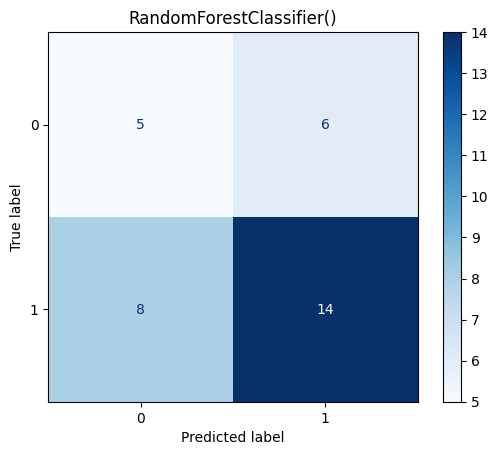

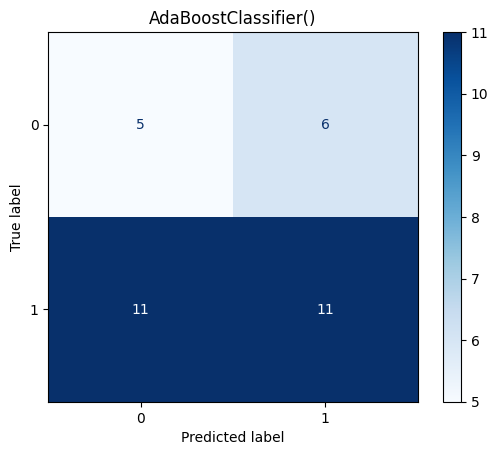

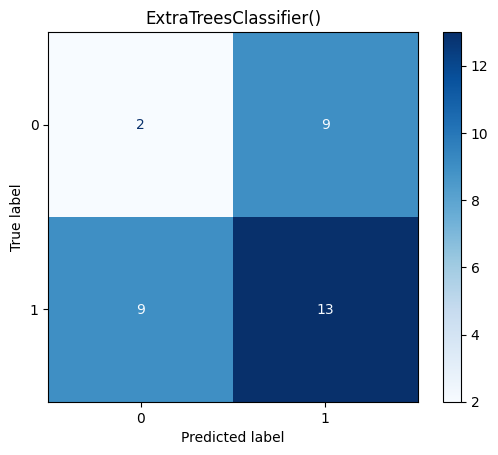

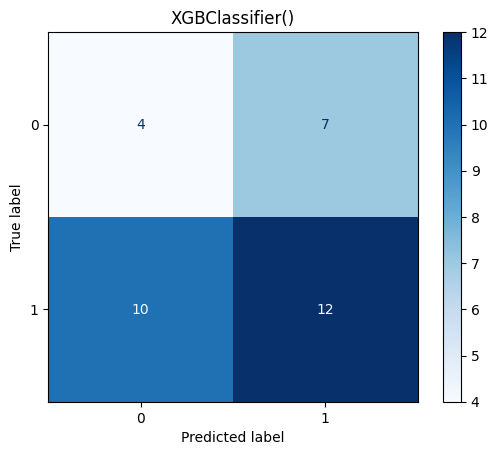

[LightGBM] [Info] Number of positive: 76, number of negative: 52
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001712 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10573
[LightGBM] [Info] Number of data points in the train set: 128, number of used features: 595
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.593750 -> initscore=0.379490
[LightGBM] [Info] Start training from score 0.379490
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

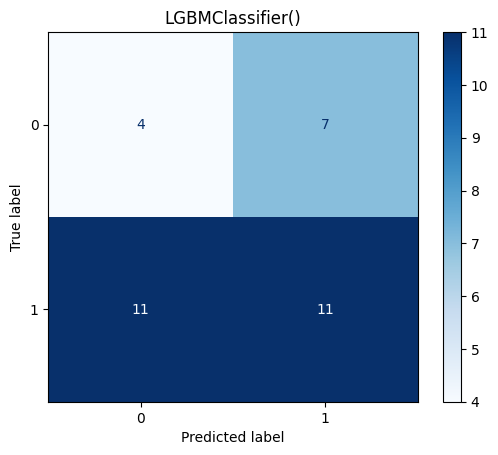

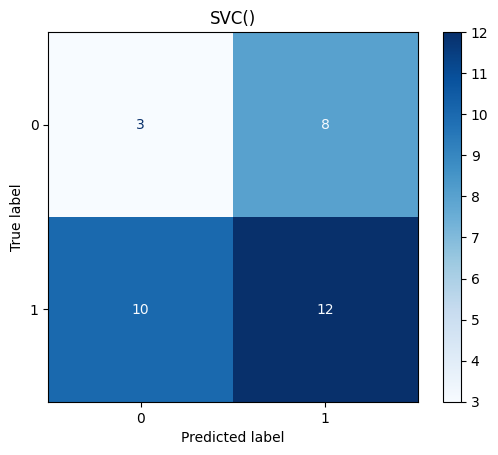

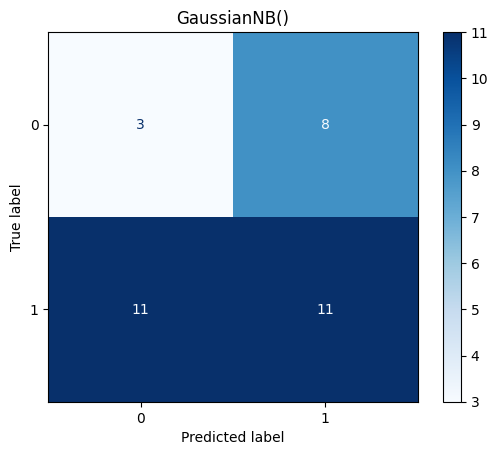

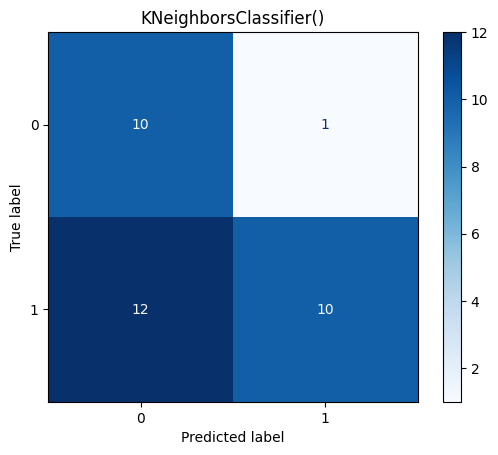

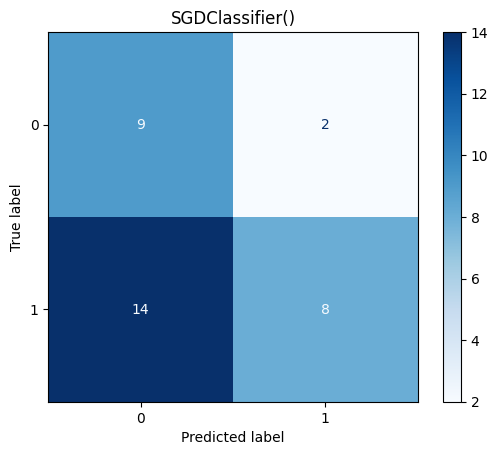

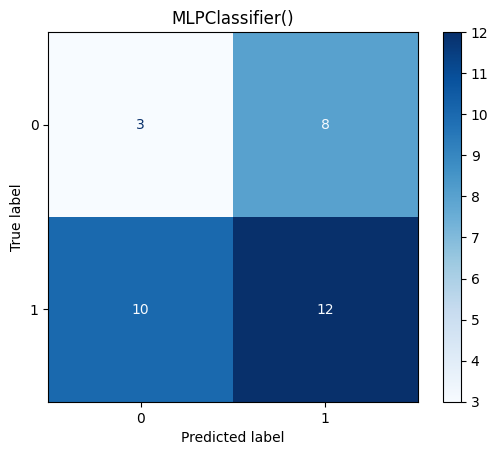

,Model,Precision,Recall,F1-score
0,KNeighborsClassifier(),0.681818,0.681818,0.606061
1,RandomForestClassifier(),0.542308,0.545455,0.541667
2,SGDClassifier(),0.595652,0.590909,0.514706
3,LogisticRegression(),0.500000,0.500000,0.497826
4,AdaBoostClassifier(),0.479779,0.477273,0.467236
5,XGBClassifier(),0.458647,0.454545,0.452683
6,DecisionTreeClassifier(),0.434524,0.431818,0.432760
7,LGBMClassifier(),0.438889,0.431818,0.428846
8,MLPClassifier(),0.415385,0.409091,0.410714
9,SVC(),0.415385,0.409091,0.410714


In [60]:
df_report = get_report_all_ml(X_train.toarray(), y_train, X_test.toarray(), y_test)
df_report

#### MPL Train & Evaluation

In [61]:
model = Model(input_dim=X.shape[1], output_dim=y.shape[1])
model.fit(X_train, y_train, validation_split=0.2, epochs=100, batch_size=32,
                    callbacks=[
                                EarlyStopping(monitor='val_loss',
                                             patience=5,
                                             restore_best_weights=True),
                                ReduceLROnPlateau(
                                  monitor='val_loss',
                                  factor=0.5,
                                  patience=5,
                                  verbose=1)
                               ]
                    )


Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 184ms/step - accuracy: 0.6080 - loss: 0.7951 - val_accuracy: 0.3846 - val_loss: 0.7569 - learning_rate: 1.0000e-06
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.5574 - loss: 0.8008 - val_accuracy: 0.4231 - val_loss: 0.7582 - learning_rate: 1.0000e-06
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.6020 - loss: 0.7661 - val_accuracy: 0.4231 - val_loss: 0.7586 - learning_rate: 1.0000e-06
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.5230 - loss: 0.8035 - val_accuracy: 0.4231 - val_loss: 0.7591 - learning_rate: 1.0000e-06
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.4744 - loss: 0.8538 - val_accuracy: 0.4231 - val_loss: 0.7597 - learning_rate: 1.0000e-06
Epoch 6/100
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.4965 - loss: 0.8017
Epoch 6: ReduceLROnPlateau reducing learning rate to 4.999999987376214e-07.
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.5175 - loss: 0.7

In [62]:
y_prob = model.predict(X_test)
best_thresholds, _ = tune_thresholds(y_test, y_prob)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
Label 0: Best threshold = 0.00, Best f1 = 0.8000


In [63]:
y_pred = (y_prob >= best_thresholds).astype(int)

In [64]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.67      1.00      0.80        22

    accuracy                           0.67        33
   macro avg       0.33      0.50      0.40        33
weighted avg       0.44      0.67      0.53        33



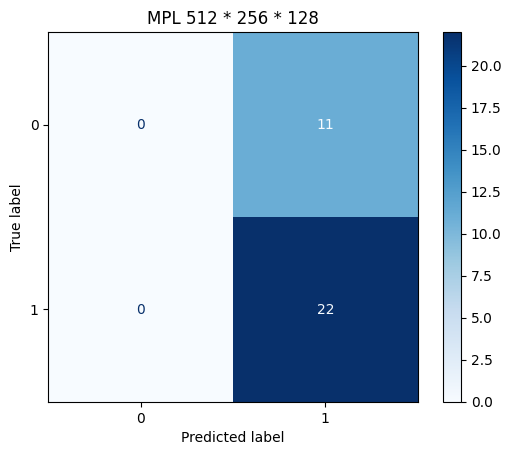

In [65]:
draw_confusion_matrix ('MPL 512 * 256 * 128', y_test, y_pred)

## Save Graph Data

In [66]:
from scripts.feature_extractions.graphs import save_graphs_and_labels_from_files

save_graphs_and_labels_from_files(hex_files, y, DATA_PATH, 'graphs_for_mint.pkl')

100%|██████████| 161/161 [00:25<00:00,  6.30it/s]

saved graphs_for_mint.pkl
